### Google Colab使用する場合

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
rawData = '/content/drive/MyDrive/■DI用/化療調製_AddDisデータ分析/AddDis調製データ.csv'
mst = '/content/drive/MyDrive/■DI用/化療調製_AddDisデータ分析/mst_data.xlsx'

### Localで編集する場合

In [1]:
rawData = 'AddDis調製データ.csv'
mst = 'mst_data.xlsx'

## マスタの確認（必要あれば修正を）

In [2]:
import pandas as pd

In [3]:
df = df = pd.read_csv(rawData, encoding='cp932')

In [4]:
df_drugs = df[['薬品コード', '薬品名']].drop_duplicates(keep='first')
krebs = pd.read_excel(mst, sheet_name='krebs')
krebs_cds = krebs['薬品コード'].to_list()
ex = pd.read_excel(mst, sheet_name='exclusion')
exclusion = ex['薬品コード'].to_list()

df_drugs = df_drugs.query('薬品コード not in @krebs_cds')
df_drugs = df_drugs.query('薬品コード not in @exclusion')

if len(df_drugs) == 0:
  print('マスタ修正は不要です')
else:
  df_drugs.to_excel('追加リスト.xlsx', index=False)
  print('マスタへの追加リストを出力しました')

マスタ修正は不要です


## 元データの整形

In [5]:
df.head()

,実施日,入外,科名,病棟,患者ID,オーダー番号,件数,本数計,薬品本数,薬品コード,...,調製時間,保留開始,保留終了,保留時間,保留合計,調製者,調製日,最終鑑査者,レジメン名称,秤量モード
0,2024/05/06,入院,消化器内科,７階東病棟,9693661,61036505-1,3,3.00,1.00,I46615,...,0:01:34,NaN,NaN,NaN,NaN,野々山 陽子,2024/05/06,本山 大夢,NaN,シリンジ抜取モード
1,2024/05/06,入院,消化器内科,７階東病棟,9693661,61036505-1,3,3.00,2.00,I89677,...,0:01:34,NaN,NaN,NaN,NaN,野々山 陽子,2024/05/06,本山 大夢,NaN,シリンジ抜取モード
2,2024/05/06,入院,血液・腫瘍内科,５階南病棟,9991433,61037011-1,2,1.35,1.00,I51679,...,0:01:12,NaN,NaN,NaN,NaN,野々山 陽子,2024/05/06,本山 大夢,NaN,個別抜取モード
3,2024/05/06,入院,血液・腫瘍内科,５階南病棟,9991433,61037011-1,2,1.35,0.35,I58207,...,0:01:12,NaN,NaN,NaN,NaN,野々山 陽子,2024/05/06,本山 大夢,NaN,個別抜取モード
4,2024/05/06,入院,血液・腫瘍内科,５階南病棟,9991433,61037016-1,2,3.65,0.20,I46587,...,0:08:43,NaN,NaN,NaN,0:04:40,野々山 陽子,2024/05/06,本山 大夢,NaN,個別抜取モード


#### str日付をdatetimeに変換

In [6]:
import datetime

In [7]:
df['実施日'] = pd.to_datetime(df['実施日'])

In [8]:
"""
df.loc[0, '調製開始']
h = int(df.loc[0, '調製開始'][0:2])  #hour
m = int(df.loc[0, '調製開始'][3:5])  #min
s= int(df.loc[0, '調製開始'][6:8])  #sec

dt = df.loc[0, '実施日']
start_dt = dt + datetime.timedelta(hours=h, minutes=m, seconds=s)
"""

"""
type(df.loc[0, '保留時間'])  #csv 空欄はfloat
"""

"\ntype(df.loc[0, '保留時間'])  #csv 空欄はfloat\n"

In [9]:
# 実行時の負荷を考えると、ある程度不要な行を削除してからの実行する方がbetter
for i in range(len(df)):
  dt = df.loc[i, '実施日']
  h1 = int(df.loc[i, '調製開始'][0:2])
  m1 = int(df.loc[i, '調製開始'][3:5])
  s1= int(df.loc[i, '調製開始'][6:8])
  df.loc[i, '調製開始'] = dt + datetime.timedelta(hours=h1, minutes=m1, seconds=s1)

  m2 = int(df.loc[i, '調製時間'][2:4])
  s2= int(df.loc[i, '調製時間'][5:7])
  df.loc[i, '調製時間'] = dt + datetime.timedelta(minutes=m2, seconds=s2)

  if type(df.loc[i, '保留時間']) == float:  #csv 空欄はfloat
    df.loc[i, '保留時間'] = dt
  else:
    m3= int(df.loc[i, '保留時間'][2:4])
    s3= int(df.loc[i, '保留時間'][5:7])
    df.loc[i, '保留時間'] = dt + datetime.timedelta(minutes=m3, seconds=s3)


In [10]:
df1 = df.query('薬品コード != @exclusion')
df1 = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始', '調製時間', '保留時間',]]
df1.sort_values('オーダー番号', ascending=True, inplace=True)

In [11]:
#オーダ番号がないレコードは削除
df1.dropna(subset='オーダー番号', inplace=True)

In [12]:
df1.head(10)

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,調製時間,保留時間
47,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:45
46,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:30
48,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:23:19
241,2024-05-07,入院,血液・腫瘍内科,５階西病棟,60050215-1,1.0,I41368,ダラキューロ配合皮下注 15m,2024-05-07 13:32:38,2024-05-07 00:02:05,2024-05-07 00:00:00
232,2024-05-07,入院,血液・腫瘍内科,５階西病棟,60050542-1,1.0,I41368,ダラキューロ配合皮下注 15m,2024-05-07 13:28:39,2024-05-07 00:01:58,2024-05-07 00:00:00
1431,2024-05-10,外来,外科,NaN,60298012-1,2.0,I55544,エピルビシン塩酸塩注射用50mg｢NK｣ Krebs,2024-05-10 14:16:33,2024-05-10 00:05:48,2024-05-10 00:02:57
1430,2024-05-10,外来,外科,NaN,60298012-1,1.0,I55543,エピルビシン塩酸塩注射用10mg｢NK｣ Krebs,2024-05-10 14:16:33,2024-05-10 00:05:48,2024-05-10 00:00:00
1434,2024-05-10,外来,外科,NaN,60298013-1,0.2,I46528,エンドキサン〔注射用〕（１００ｍｇ） Krebs,2024-05-10 14:09:07,2024-05-10 00:27:23,2024-05-10 00:18:06
1435,2024-05-10,外来,外科,NaN,60298013-1,2.0,I46528,エンドキサン〔注射用〕（１００ｍｇ） Krebs,2024-05-10 14:09:07,2024-05-10 00:27:23,2024-05-10 00:17:44
1436,2024-05-10,外来,外科,NaN,60298013-1,1.0,I46530,エンドキサン ５００ｍｇ〔注射用〕 Krebs,2024-05-10 14:09:07,2024-05-10 00:27:23,2024-05-10 00:22:37


In [13]:
df1 = pd.merge(df1, krebs, how='inner')
#df1.sort_values('オーダー番号', ascending=True, inplace=True)
df1.tail(10)

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,調製時間,保留時間,stem,contain
786,2024-05-10,入院,小児科,９階西病棟,61159257-1,1.0000,I46709,オンコビン注射用 １ｍｇ Krebs,2024-05-10 09:38:31,2024-05-10 00:07:00,2024-05-10 00:02:18,VCR,1.0
787,2024-05-10,入院,小児科,９階西病棟,61159257-1,0.3800,I46709,オンコビン注射用 １ｍｇ Krebs,2024-05-10 09:38:31,2024-05-10 00:07:00,2024-05-10 00:01:58,VCR,1.0
788,2024-05-08,入院,血液・腫瘍内科,５階南病棟,61140620-1,1.0000,I62639,リツキシマブBS点滴静注500mg｢KHK｣ 50mL Krebs,2024-05-08 09:27:01,2024-05-08 00:05:03,2024-05-08 00:00:00,Rit,500.0
789,2024-05-12,入院,血液・腫瘍内科,５階南病棟,61213699-1,2.7000,I62639,リツキシマブBS点滴静注,2024-05-12 09:58:52,2024-05-12 00:06:11,2024-05-12 00:00:00,Rit,500.0
790,2024-05-09,入院,血液・腫瘍内科,５階南病棟,61140853-1,1.0000,I45781,イホマイド １ｇ〔注射用〕 Krebs,2024-05-09 09:14:24,2024-05-09 00:03:50,2024-05-09 00:00:00,IFO,1000.0
791,2024-05-10,入院,血液・腫瘍内科,５階南病棟,61140860-1,1.0000,I45781,イホマイド １ｇ〔注射用〕 Krebs,2024-05-10 08:46:13,2024-05-10 00:04:38,2024-05-10 00:00:00,IFO,1000.0
792,2024-05-11,入院,血液・腫瘍内科,５階南病棟,61140862-1,1.0000,I45781,イホマイド １ｇ〔注射用〕 Krebs,2024-05-11 09:22:49,2024-05-11 00:04:10,2024-05-11 00:01:41,IFO,1000.0
793,2024-05-09,入院,血液・腫瘍内科,５階南病棟,61161819-1,0.0400,I17763,エプキンリ皮下注4mg Krebs,2024-05-09 13:54:34,2024-05-09 00:00:31,2024-05-09 00:00:00,エプキンリ,4.0
794,2024-05-09,入院,血液・腫瘍内科,５階南病棟,61162011-1,0.9167,I50996,妊禁 授禁 トリセノックス点滴,2024-05-09 09:41:14,2024-05-09 00:02:34,2024-05-09 00:00:00,トリセノックス,12.0
795,2024-05-10,入院,血液・腫瘍内科,５階南病棟,61162014-1,0.9167,I50996,妊禁 授禁 トリセノックス点滴,2024-05-10 09:35:13,2024-05-10 00:01:47,2024-05-10 00:00:00,トリセノックス,12.0


#### オーダー番号と用量（合計）の紐づけ

In [14]:
df1['mg'] = df1['薬品本数'] * df1['contain']
#df1.head()

In [15]:
df1

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,調製時間,保留時間,stem,contain,mg
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0000,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:45,カイプロリス,40.0,40.0000
1,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0000,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:30,カイプロリス,40.0,40.0000
2,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0000,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:23:19,カイプロリス,40.0,40.0000
3,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0000,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:37,カイプロリス,40.0,40.0000
4,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0000,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:18,カイプロリス,40.0,40.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,2024-05-10,入院,血液・腫瘍内科,５階南病棟,61140860-1,1.0000,I45781,イホマイド １ｇ〔注射用〕 Krebs,2024-05-10 08:46:13,2024-05-10 00:04:38,2024-05-10 00:00:00,IFO,1000.0,1000.0000
792,2024-05-11,入院,血液・腫瘍内科,５階南病棟,61140862-1,1.0000,I45781,イホマイド １ｇ〔注射用〕 Krebs,2024-05-11 09:22:49,2024-05-11 00:04:10,2024-05-11 00:01:41,IFO,1000.0,1000.0000
793,2024-05-09,入院,血液・腫瘍内科,５階南病棟,61161819-1,0.0400,I17763,エプキンリ皮下注4mg Krebs,2024-05-09 13:54:34,2024-05-09 00:00:31,2024-05-09 00:00:00,エプキンリ,4.0,0.1600
794,2024-05-09,入院,血液・腫瘍内科,５階南病棟,61162011-1,0.9167,I50996,妊禁 授禁 トリセノックス点滴,2024-05-09 09:41:14,2024-05-09 00:02:34,2024-05-09 00:00:00,トリセノックス,12.0,11.0004


In [16]:
dose = df1.pivot_table(index='オーダー番号', values='mg', aggfunc='sum')
dose.reset_index(inplace=True)
dose.head()

,オーダー番号,mg
0,59983940-1,120.0
1,60050215-1,15.0
2,60050542-1,15.0
3,60298012-1,110.0
4,60298013-1,720.0


#### 調製時間の算出

In [17]:
prep_times = []
for i in range(len(df1)):
    tdelta = df1.loc[i, '調製時間'] - df1.loc[i, '保留時間']
    prep_times.append(tdelta)
df1['prep_time'] = prep_times

In [18]:
df1.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,調製時間,保留時間,stem,contain,mg,prep_time
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:45,カイプロリス,40.0,40.0,0 days 00:04:59
1,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:30,カイプロリス,40.0,40.0,0 days 00:05:14
2,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:23:19,カイプロリス,40.0,40.0,0 days 00:04:25
3,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:37,カイプロリス,40.0,40.0,0 days 00:05:43
4,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:18,カイプロリス,40.0,40.0,0 days 00:06:02


In [19]:
#df1['調製時間'] = pd.to_datetime(df1['調製時間'])
#df1['保留時間'].fillna('00:00:00', inplace=True)
#df1['保留時間'] = pd.to_datetime(df1['保留時間'])

#prep_time
prep_times = []
for i in range(len(df1)):
    tdelta = df1.loc[i, '調製時間'] - df1.loc[i, '保留時間']
    sec = tdelta.total_seconds()  #秒に換算
    prep_times.append(sec/60)
df1['prep_time'] = prep_times

In [20]:
df1 = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始', 'stem', 'contain', 'prep_time']]

In [21]:
df1.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333
1,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,5.233333
2,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.416667
3,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667
4,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,6.033333


In [22]:
df1.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)
df1 = pd.merge(df1, dose, how='outer')
#df1.head(15)

C:\Users\hmill\AppData\Local\Temp\ipykernel_20248\1489245902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)


In [23]:
#df1.reset_index(inplace=True)  #for文でloc使用するためにindexを0から振り直す

In [24]:
hours = []
for i in range(len(df1)):
    hour = df1.loc[i, '調製開始'].strftime('%H時')
    hours.append(hour)
df1['hour'] = hours

In [25]:
df1.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,mg,hour
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333,120.0,08時
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667,100.0,14時
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,3.916667,90.0,08時
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,4.000000,90.0,08時
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,7.933333,130.0,14時


## データの可視化

#### 調製件数（1日分のデータ）

In [26]:
df2 = pd.pivot_table(df1,
                     index='hour', columns='入外', values='オーダー番号',
                     aggfunc='count'
                     )

In [27]:
df2

入外,入院,外来
hour,,
08時,21.0,17.0
09時,109.0,38.0
10時,43.0,68.0
11時,13.0,75.0
12時,10.0,41.0
13時,11.0,44.0
14時,3.0,47.0
15時,1.0,26.0
16時,NaN,1.0


In [28]:
df2.reset_index(inplace=True)

In [29]:
!pip install japanize_matplotlib

    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

<AxesSubplot: >

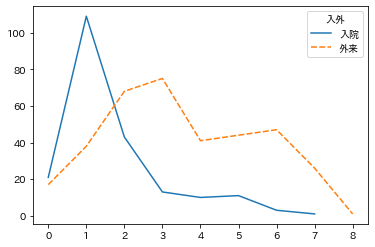

In [31]:
#sns.set_theme(style="darkgrid")
sns.lineplot(df2)

In [32]:
df2.set_index('hour', inplace=True)

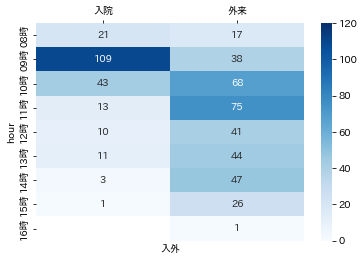

In [34]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(df2, annot=True, fmt='g', cmap='Blues', vmax=120, vmin=0)
ax.xaxis.tick_top()

In [35]:
import numpy as np

In [36]:
position = np.arange(len(df2.index))
gap = 0.2
# 2つ目の系列のポジション
print(position+gap)

[0.2 1.2 2.2 3.2 4.2 5.2 6.2 7.2 8.2]


In [37]:
df2.reset_index(inplace=True)

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

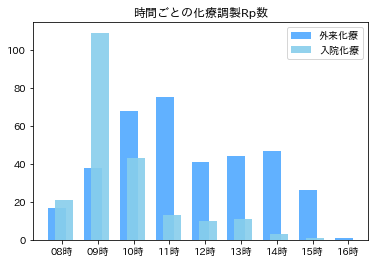

In [38]:
plt.bar(position, df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(position+gap, df2['入院'], width=0.5, alpha=0.9, color='skyblue', label='入院化療')
plt.xticks(position+gap*2/3, df2['hour'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

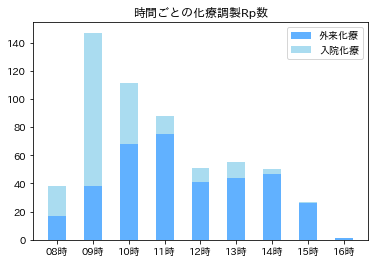

In [39]:
plt.bar(df2['hour'], df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(df2['hour'], df2['入院'], width=0.5, alpha=0.7, color='skyblue', label='入院化療', bottom=df2['外来'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

#### 参考

In [128]:
import altair as alt
from vega_datasets import data

In [129]:
source = data.cars()
source.head()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


In [139]:
line = alt.Chart(source).mark_line().encode(
    x='Year',
    y='mean(Miles_per_Gallon)'
)
band = alt.Chart(source).mark_errorband(extent='ci').encode(
    x='Year',
    y=alt.Y('Miles_per_Gallon', title='Miles/Gallon'),
)

band + line

alt.LayerChart(...)

#### 調製件数（複数日データ）

In [40]:
df1.columns

Index(['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始',
       'stem', 'contain', 'prep_time', 'mg', 'hour'],
      dtype='object')

In [41]:
df22 = df1.pivot_table(index=['実施日', 'hour'], columns='入外', values='オーダー番号', aggfunc='count')

In [42]:
df22.reset_index(inplace=True)

In [43]:
df22.head()

入外,実施日,hour,入院,外来
0,2024-05-06,09時,11.0,NaN
1,2024-05-06,10時,2.0,NaN
2,2024-05-07,08時,2.0,4.0
3,2024-05-07,09時,10.0,13.0
4,2024-05-07,10時,6.0,14.0


In [44]:
df23 = pd.melt(df22, id_vars=['実施日', 'hour'], value_vars=['入院', '外来'], var_name='入外', value_name='count')
df23.head()

,実施日,hour,入外,count
0,2024-05-06,09時,入院,11.0
1,2024-05-06,10時,入院,2.0
2,2024-05-07,08時,入院,2.0
3,2024-05-07,09時,入院,10.0
4,2024-05-07,10時,入院,6.0


In [45]:
import altair as alt

In [46]:
line = alt.Chart(df23).mark_line().encode(
          x='hour',
          y='mean(count)',
          color='入外',
          tooltip=['hour', 'mean(count)']
          ).properties(
                    width=800,
                    height=400
                    )


band = alt.Chart(df23).mark_errorband(extent='ci').encode(
    x='hour',
    y=alt.Y('count', title='時間あたりの調製件数'),
    color='入外',
)

line + band

alt.LayerChart(...)

#### 医薬品ごとの調製時間

In [148]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c87f93a27e42923a805c58e701f9982733dbdd6177fc1bda363450f9ec47cc1c
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [47]:
df1.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,mg,hour
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333,120.0,08時
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667,100.0,14時
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,3.916667,90.0,08時
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,4.000000,90.0,08時
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,7.933333,130.0,14時


In [48]:
df1 = df1.dropna(subset='stem') #マスタにない薬剤（Nan）を削除

In [49]:
"""
df3 = df1.query('stem == "PTX"')
sns.jointplot(x="mg", y="prep_time", data=df3,
              kind="reg",
              xlim=(0, df3['mg'].max()*1.1), ylim=(0, df3['prep_time'].max()*1.1),
              color="c",
              height=5
              )
"""

'\ndf3 = df1.query(\'stem == "PTX"\')\nsns.jointplot(x="mg", y="prep_time", data=df3,\n              kind="reg",\n              xlim=(0, df3[\'mg\'].max()*1.1), ylim=(0, df3[\'prep_time\'].max()*1.1),\n              color="c",\n              height=5\n              )\n'

In [50]:
#選択した薬剤の用量別調製時間を確認
drugs = df1['stem'].unique().tolist()
def create_jointplot(num):
  drug = drugs[num]
  df3 = df1.query('stem == @drug')
  p = sns.jointplot(x="mg", y="prep_time", data=df3,
                  kind="reg",
                  xlim=(0, df3['mg'].max()*1.1), ylim=(0, df3['prep_time'].max()*1.1),
                  color="m",
                  height=5
                  )
  return drug, p

DTX


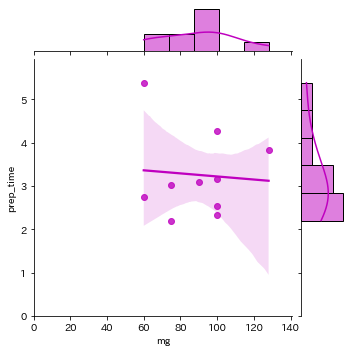

In [51]:
fig = create_jointplot(16)
print(fig[0])
print(fig[1])

薬剤名:カイプロリス
薬剤名:ダラキュ―ロ
薬剤名:EPI
薬剤名:CPA
薬剤名:Aza
薬剤名:PTX
薬剤名:Rit
薬剤名:nabPTX
薬剤名:GEM
薬剤名:オプジーボ
薬剤名:サイラムザ
薬剤名:キイトルーダ
薬剤名:PEM
薬剤名:ジェブタナ
薬剤名:ベクティビックス
薬剤名:5-FU
薬剤名:DTX
薬剤名:ベルケイド
薬剤名:パージェタ
薬剤名:ハーセプチン


c:\Users\hmill\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


薬剤名:アバスチン
薬剤名:MTX
薬剤名:テセントリク
薬剤名:フェスゴMA
薬剤名:CDDP
薬剤名:イミフィンジ
薬剤名:トレアキシン
薬剤名:ヤーボイ
薬剤名:CBDCA
薬剤名:THP-ADR
薬剤名:ビーリンサイト
薬剤名:カドサイラ
薬剤名:ダカルバジン
薬剤名:アドセトリス
薬剤名:エクザール
薬剤名:ドキソルビシン
薬剤名:ポライビー
薬剤名:ADR
薬剤名:エルプラット
薬剤名:カルセド
薬剤名:バベンチオ
薬剤名:ハラヴェン
薬剤名:ロイナーゼ
薬剤名:エプキンリ
薬剤名:CPT-11
薬剤名:ガザイバ
薬剤名:AraC
薬剤名:アービタックス
薬剤名:パドセブ
薬剤名:ETP
薬剤名:フェスゴIN
薬剤名:コスメゲン
薬剤名:Flu
薬剤名:L-PAM
薬剤名:DNR
薬剤名:エンハーツ
薬剤名:ドキシル
薬剤名:ジフォルタ
薬剤名:Benda
薬剤名:BU
薬剤名:VCR
薬剤名:IFO
薬剤名:トリセノックス


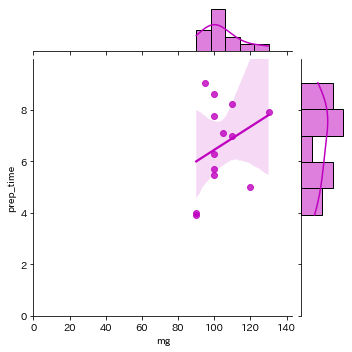

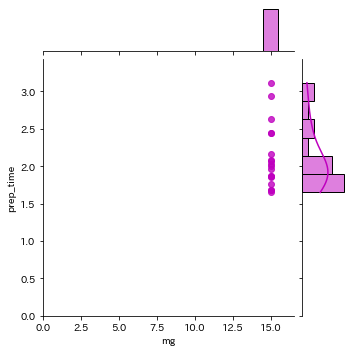

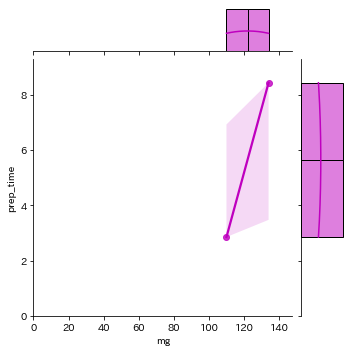

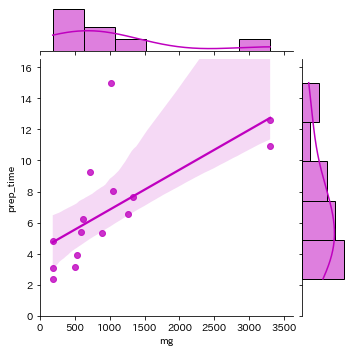

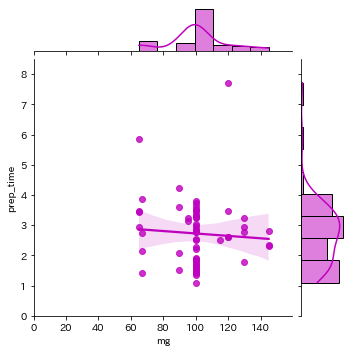

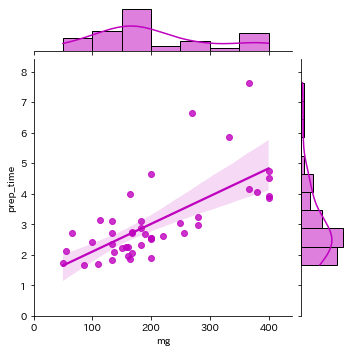

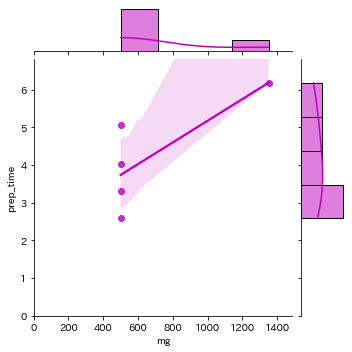

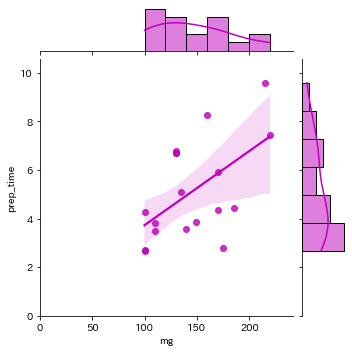

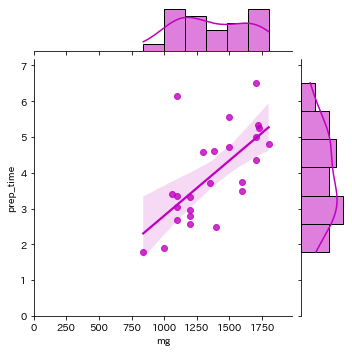

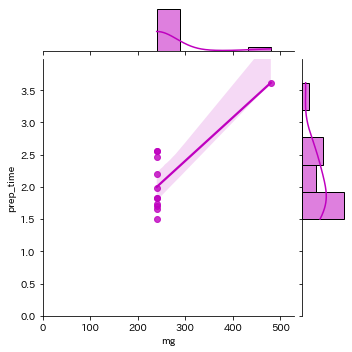

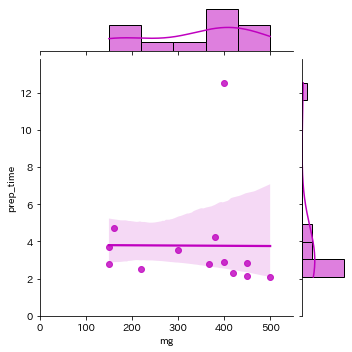

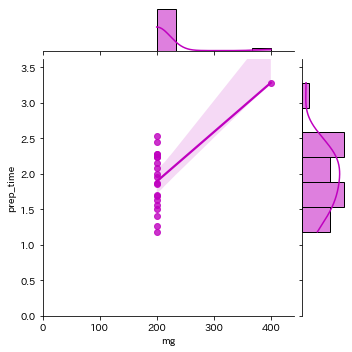

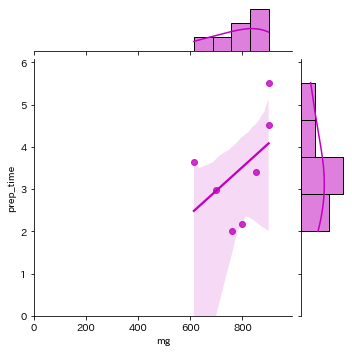

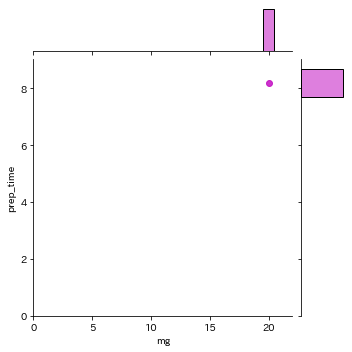

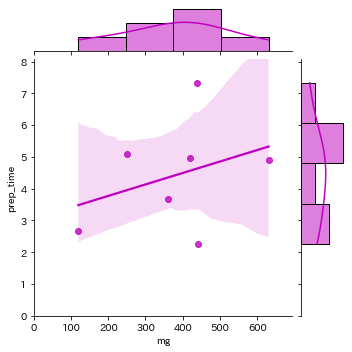

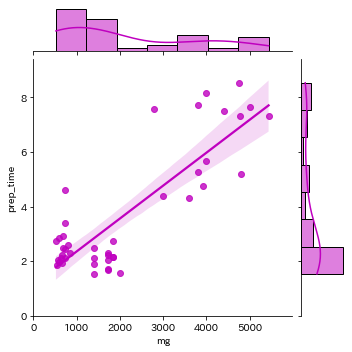

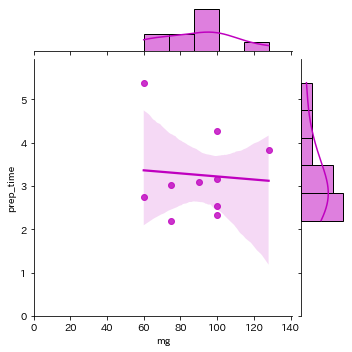

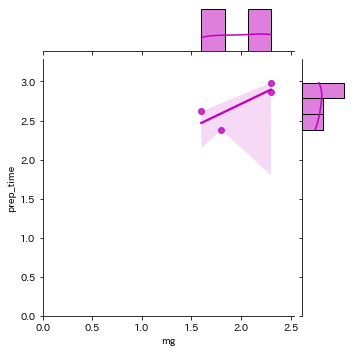

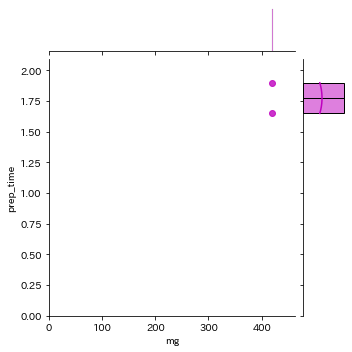

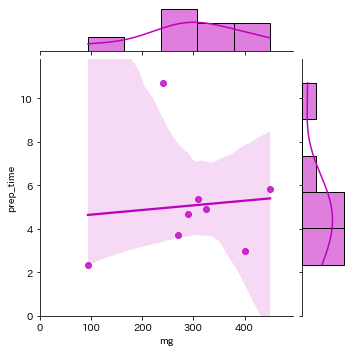

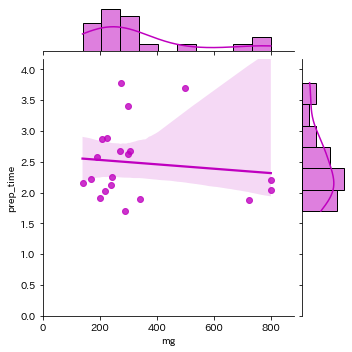

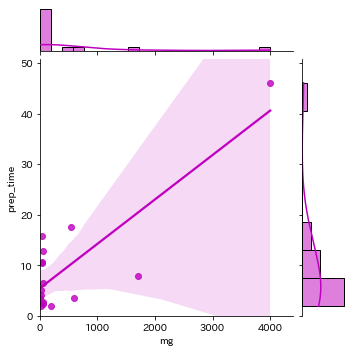

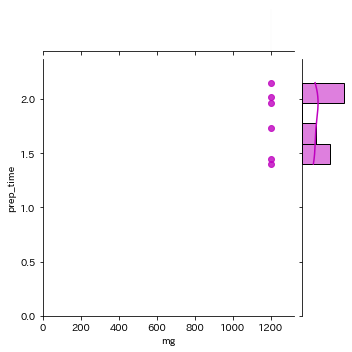

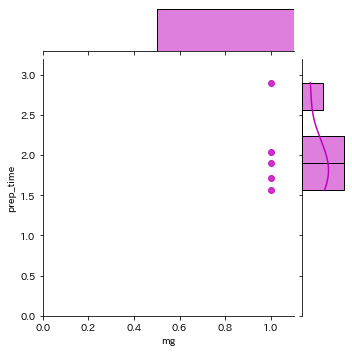

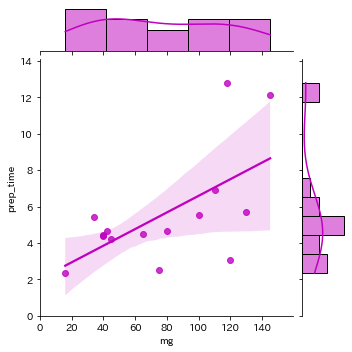

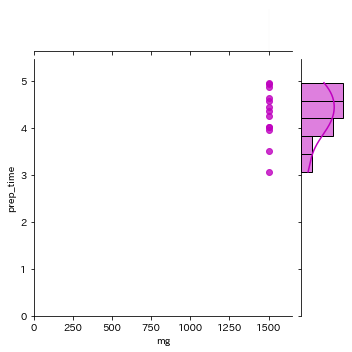

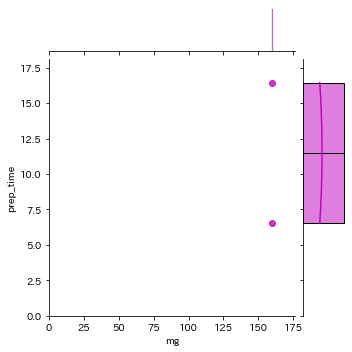

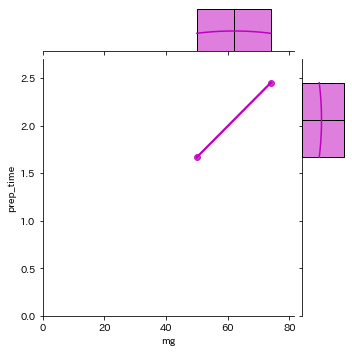

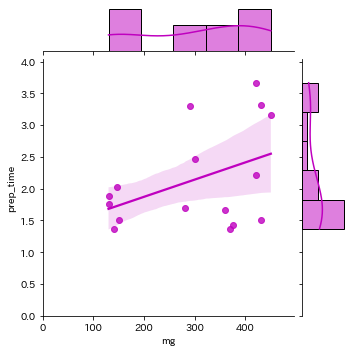

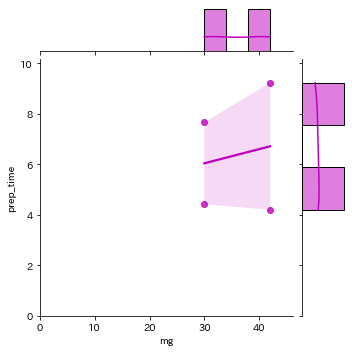

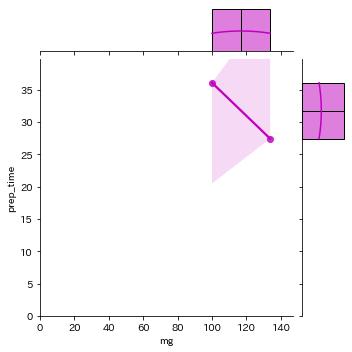

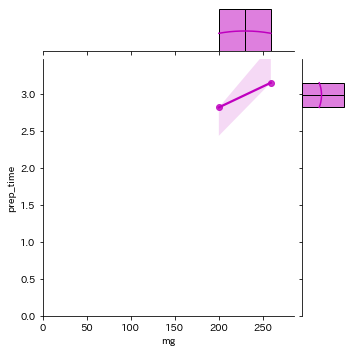

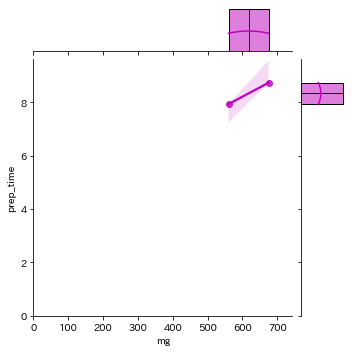

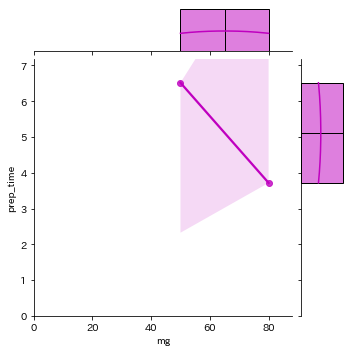

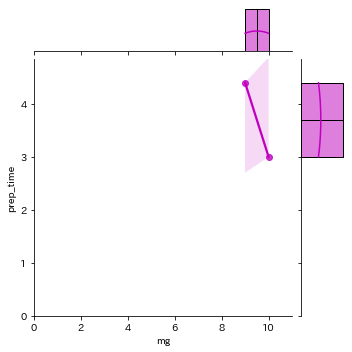

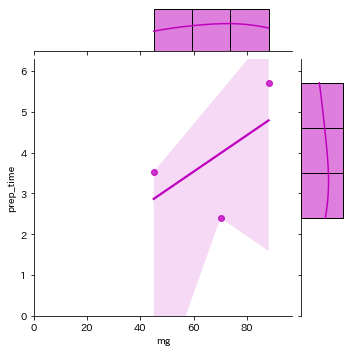

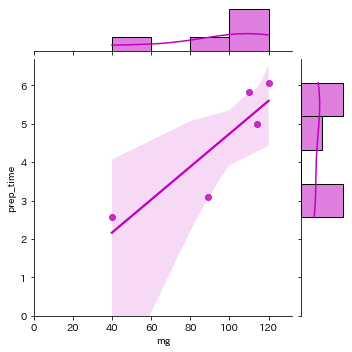

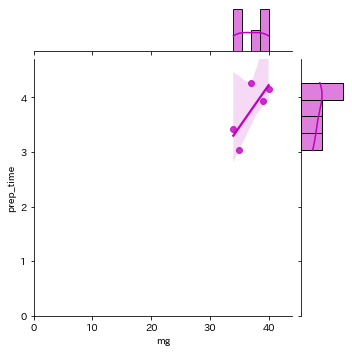

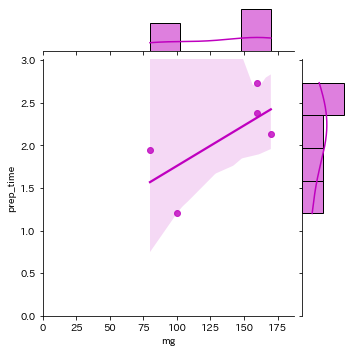

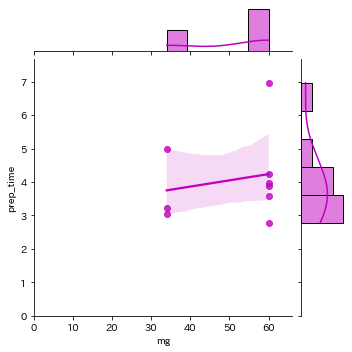

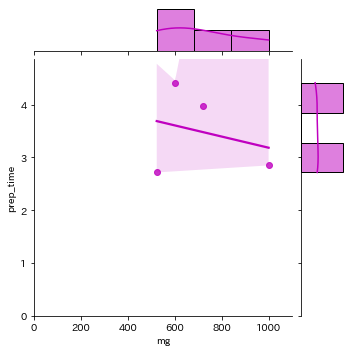

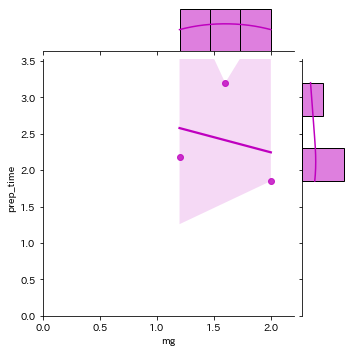

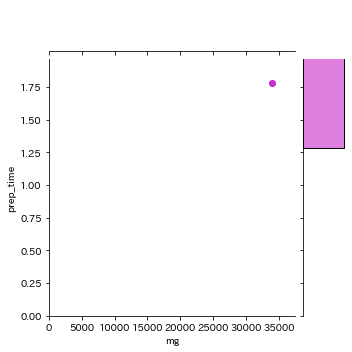

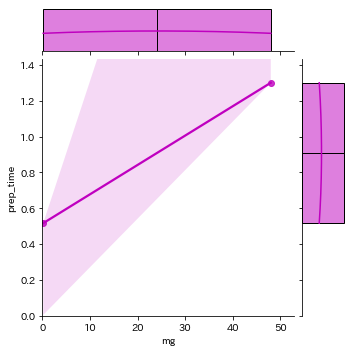

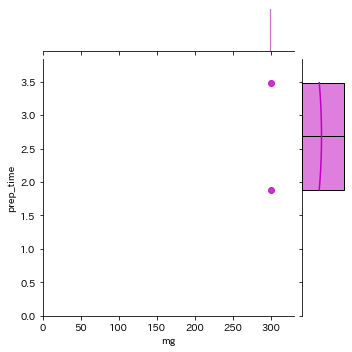

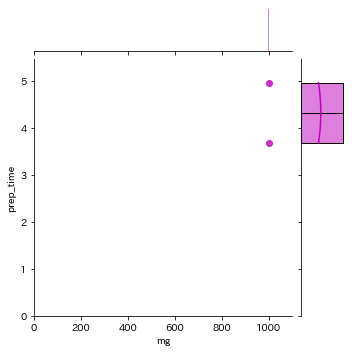

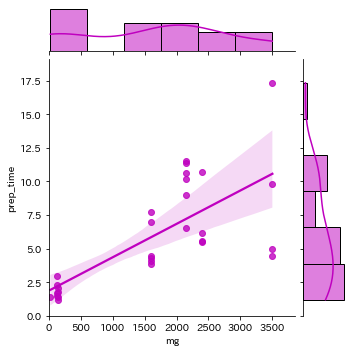

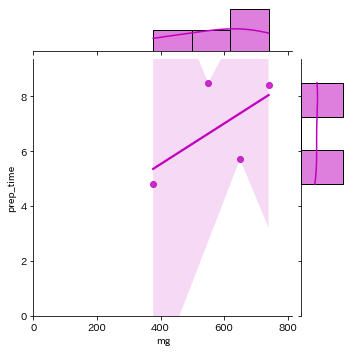

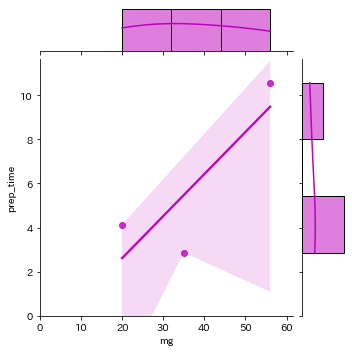

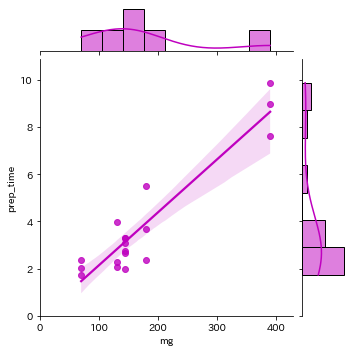

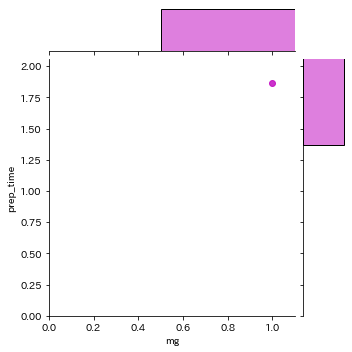

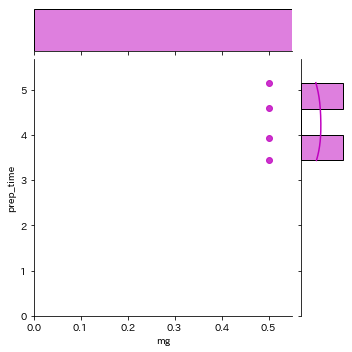

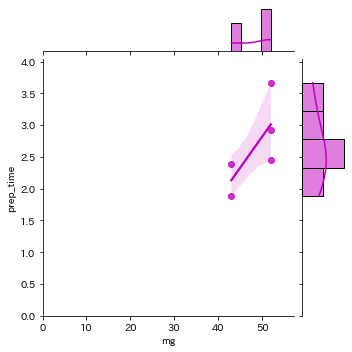

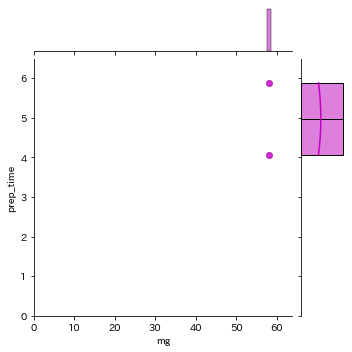

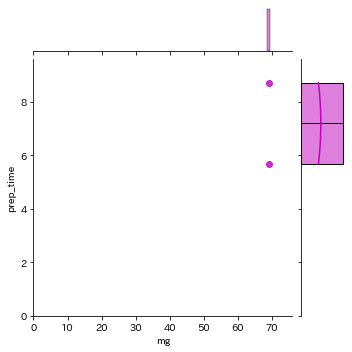

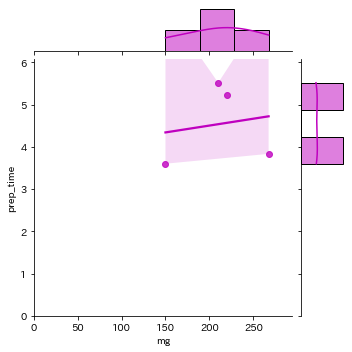

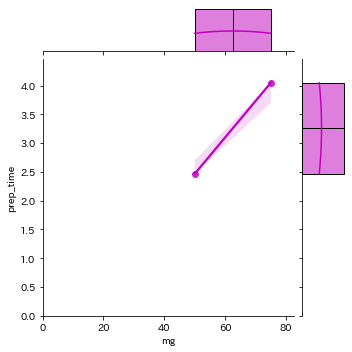

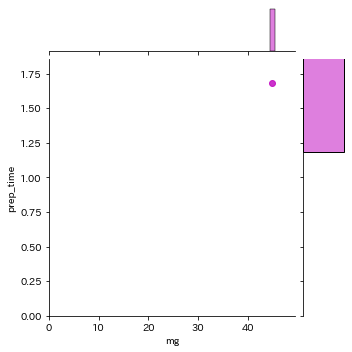

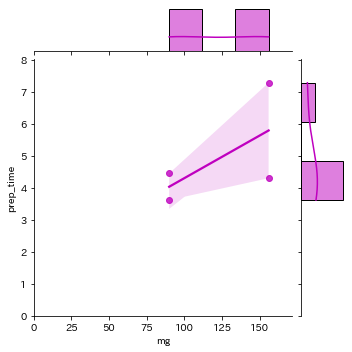

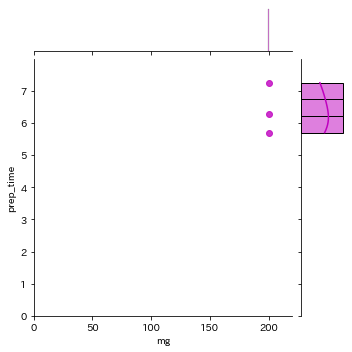

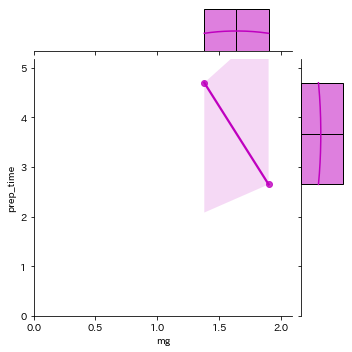

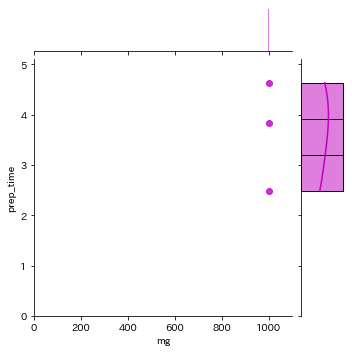

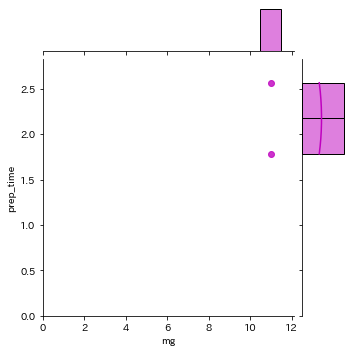

In [52]:
for i in range(len(drugs)):
  fig = create_jointplot(i)
  print(f'薬剤名:{fig[0]}')
  print(fig[1])

https://qiita.com/skotaro/items/7fee4dd35c6d42e0ebae

<メモ>  
年次と調製時間 ポインターを合わせればmgが分かるようにする

髄注など複数薬剤が含まれるRpはひろえない

#### オーダ番号と調製者を紐づけ

In [53]:
mkr = df[['オーダー番号', '調製者']]
mkr.drop_duplicates(keep='first', inplace=True)
mkr.head()

C:\Users\hmill\AppData\Local\Temp\ipykernel_20248\812680933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkr.drop_duplicates(keep='first', inplace=True)


,オーダー番号,調製者
0,61036505-1,野々山 陽子
2,61037011-1,野々山 陽子
4,61037016-1,野々山 陽子
7,61036054-1,野々山 陽子
9,61036055-1,野々山 陽子


In [54]:
df4 = pd.merge(df1, mkr, how='inner')
df4.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,mg,hour,調製者
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333,120.0,08時,鈴木 里麻
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667,100.0,14時,鈴木 里麻
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,3.916667,90.0,08時,鈴木 里麻
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,4.000000,90.0,08時,森﨑 萌
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,7.933333,130.0,14時,山下拓海


In [55]:
num = 1
drug = drugs[num]
df4q = df4.query('stem == @drug')
df4qp = df4q.pivot_table(index='調製者', values=['prep_time'], aggfunc=['count', 'min', 'max', 'mean'])
df4qp.columns = ['回数', 'min', 'max', '平均']
df4qp.sort_values('平均', ascending=True, inplace=True)
df4qp.reset_index(inplace=True)
df4qp.rename(columns={'調製者': f'{drug}'}, inplace=True)
df4qp.set_index(f'{drug}', inplace=True)
print(drug)
df4qp.head()

ダラキュ―ロ


,回数,min,max,平均
ダラキュ―ロ,,,,
渡邊晃平,1,1.683333,1.683333,1.683333
森﨑 萌,3,1.683333,2.033333,1.861111
鈴木 里麻,6,1.650000,2.083333,1.863889
阿部 彩香,1,2.066667,2.066667,2.066667
山下拓海,3,2.000000,2.633333,2.266667


In [56]:
def preptime_rank(num):
  drug = drugs[num]
  df4q = df4.query('stem == @drug')
  df4qp = df4q.pivot_table(index='調製者', values='prep_time', aggfunc=['count', 'min', 'max', 'mean'])
  df4qp.columns = ['回数', 'min', 'max', '平均']
  df4qp.sort_values('平均', ascending=True, inplace=True)
  return drug, df4qp

In [57]:
for i in range(len(drugs)):
  rank = preptime_rank(i)
  print('------------------------------------------------------')
  print(f'【{rank[0]}】')
  print(rank[1])
  print()


------------------------------------------------------
【カイプロリス】
        回数       min       max        平均
調製者                                     
森﨑 萌     1  4.000000  4.000000  4.000000
鈴木 里麻    4  3.916667  7.000000  5.404167
本山 大夢    1  6.300000  6.300000  6.300000
小島 礼菜    2  5.466667  8.216667  6.841667
池田 のどか   2  7.116667  9.050000  8.083333
山下拓海     3  7.750000  8.600000  8.094444

------------------------------------------------------
【ダラキュ―ロ】
        回数       min       max        平均
調製者                                     
渡邊晃平     1  1.683333  1.683333  1.683333
森﨑 萌     3  1.683333  2.033333  1.861111
鈴木 里麻    6  1.650000  2.083333  1.863889
阿部 彩香    1  2.066667  2.066667  2.066667
山下拓海     3  2.000000  2.633333  2.266667
小島 礼菜    2  2.450000  2.450000  2.450000
池田 のどか   2  2.933333  3.116667  3.025000

------------------------------------------------------
【EPI】
       回数       min       max        平均
調製者                                    
谷 江梨奈   1  2.850000  2.850000  2